In [1]:
# Imports here
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import cv2
from tqdm import tqdm
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torchviz import make_dot, make_dot_from_trace
from torch.utils.data import DataLoader, Dataset
import os
import torch.nn.functional as F
from torchsummary import summary
from torchvision.datasets import CIFAR10
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
import time
import pathlib
from torch.optim import Adam
from torch.autograd import Variable
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

In [2]:
data_dir = pathlib.Path('./real_data')
data_dir

PosixPath('real_data')

# 手動label encoder，若是資料多，則無法使用

In [3]:
#手動label encoder，若是資料多，則無法使用
cats = list(data_dir.glob('cats/*'))
dogs = list(data_dir.glob('dogs/*'))
flowers = list(data_dir.glob('flowers/*'))
horses = list(data_dir.glob('horses/*'))
human = list(data_dir.glob('human/*'))
df_labels = {
    'cats' : 0,
    'dogs' : 1,
    'flowers' : 2,
    'horses' : 3,
    'human' : 4
 }
class_names = ['cats', 'dogs', 'flowers','horses', 'human']
num_class = len(class_names)

image_files = [[os.path.join(data_dir, class_name, x) for x in os.listdir(os.path.join(data_dir, class_name))] for class_name in class_names]

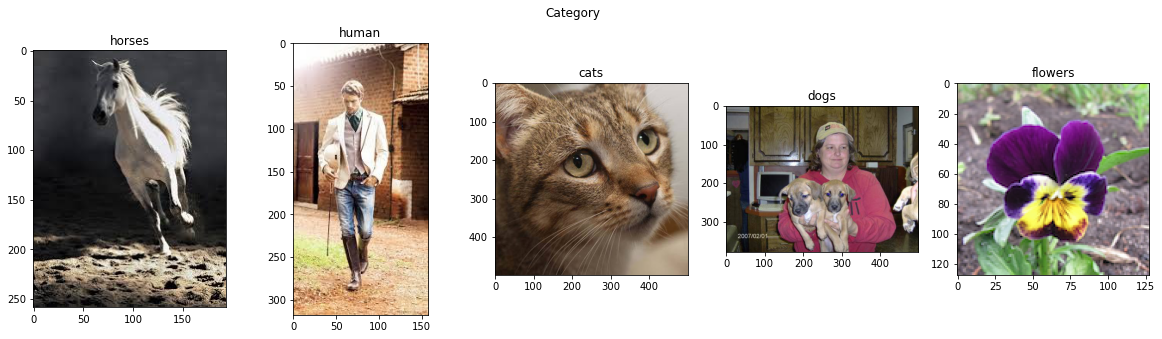

In [4]:
import matplotlib.image as img
fig, ax = plt.subplots(ncols = 5, figsize = (20,5))
fig.suptitle('Category')

cats_image = img.imread(cats[0])
dogs_image = img.imread(dogs[0])
flowers_image = img.imread(flowers[0])
horses_image = img.imread(horses[0])
human_image = img.imread(human[0])

ax[0].set_title('horses')
ax[1].set_title('human')
ax[2].set_title('cats')
ax[3].set_title('dogs')
ax[4].set_title('flowers')


ax[0].imshow(horses_image)
ax[1].imshow(human_image)
ax[2].imshow(cats_image)
ax[3].imshow(dogs_image)
ax[4].imshow(flowers_image)


plt.show()

In [5]:
images_paths = []
for i in range(num_class):
    for j in range(len(image_files[i])):
        current = image_files[i]
        images_paths.append(current[j])
print(f"Number of image {len(images_paths)}")

Number of image 1018


In [6]:
training_transforms = transforms.Compose([transforms.Resize(256),
                                          transforms.RandomResizedCrop(224),
                                          transforms.RandomHorizontalFlip(),
                                          transforms.ToTensor(),
                                          transforms.Normalize([0.485, 0.456, 0.406], 
                                                               [0.229, 0.224, 0.225])])

validation_transforms = transforms.Compose([transforms.Resize(256),
                                            transforms.CenterCrop(224),
                                            transforms.ToTensor(),
                                            transforms.Normalize([0.485, 0.456, 0.406], 
                                                                 [0.229, 0.224, 0.225])])

testing_transforms = transforms.Compose([transforms.Resize(256),
                                         transforms.CenterCrop(224),
                                         transforms.ToTensor(),
                                         transforms.Normalize([0.485, 0.456, 0.406], 
                                                              [0.229, 0.224, 0.225])])

## 手動切割資料集

In [7]:
import random

random.shuffle(images_paths)

train_paths = images_paths[:800]
test_paths = images_paths[800:900]
valid_paths = images_paths[900:]

In [8]:
train_paths[0]

'real_data/flowers/0183.png'

In [9]:
from torch.utils.data import Dataset
from random import randint
from PIL import Image
class ImageDataset(Dataset):
    def __init__(self, df_labels, base_dir, transform=None):
        super().__init__()
    
        self.base_dir = base_dir
        self.df_labels = df_labels
        self.transform = transform
        
    def __len__(self):
        return len(self.base_dir)
    
    def __getitem__(self, index):
        
        image_path = self.base_dir[index]
        
        image = Image.open(image_path).convert('RGB') ## 因為可能dataset有4維，所以要轉成RGB
        
        #get label
        label_name = image_path.split('/')[-2]
        
        #label encoding 
        label = self.df_labels[label_name]
        
        if self.transform is not None:
            image = self.transform(image)
        return (image, label)

In [10]:
train_data = ImageDataset(df_labels, train_paths, training_transforms)
test_data = ImageDataset(df_labels, test_paths, testing_transforms)
valid_data = ImageDataset(df_labels, valid_paths, validation_transforms)

In [32]:
from torch.utils.data import DataLoader
train_loader = DataLoader(train_data, batch_size = 8, shuffle = True)  #load 800 images once
valid_loader = DataLoader(valid_data, batch_size = 8, shuffle = True) #load 120 images once
test_loader = DataLoader(test_data, batch_size = 8, shuffle = True) #load 104 images once
#len of dataloader is number of batch

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision
# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
print(images.shape)
# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{labels[j]}' for j in range(8)))

In [ ]:
# Function to show the images
def imageshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# Function to test the model with a batch of images and show the labels predictions
def testBatch():
    # get batch of images from the test DataLoader  
    images, labels = next(iter(test_loader))

    # show all images as one image grid
    imageshow(torchvision.utils.make_grid(images))
   
    # Show the real labels on the screen 
    print('Real labels: ', ' '.join('%5s' % classes[labels[j]] 
                               for j in range(batch_size)))
    outputs = model(images)
    
    _, predicted = torch.max(outputs, 1)
    
    print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] 
                              for j in range(batch_size)))

In [ ]:
# Function to save the model
def saveModel():
    path = "./ResNet18+intel.pth"
    torch.save(model.state_dict(), path)

# Function to test the model with the test dataset and print the accuracy for the test images
def testAccuracy():
    model.eval()
    accuracy = 0.0
    total = 0.0
    
    with torch.no_grad():
        for data in valid_loader:
            images, labels = data
            images = Variable(images.to(device))
            labels = Variable(labels.to(device))
            # run the model on the test set to predict labels
            outputs = model(images)
            # the label with the highest energy will be our prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            accuracy += (predicted == labels).sum().item()
    
    # compute the accuracy over all test images
    accuracy = (100 * accuracy / total)
    return(accuracy)

In [ ]:
class Block(nn.Module):
    
    def __init__(self, in_channels, out_channels, identity_downsample=None, stride=1):
        super(Block, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample
        
    def forward(self, x):
        identity = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)
        x += identity
        x = self.relu(x)
        return x

class ResNet_18(nn.Module):
    
    def __init__(self, image_channels, num_classes):
        
        super(ResNet_18, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        #resnet layers
        self.layer1 = self.__make_layer(64, 64, stride=1)
        self.layer2 = self.__make_layer(64, 128, stride=2)
        self.layer3 = self.__make_layer(128, 256, stride=2)
        self.layer4 = self.__make_layer(256, 512, stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)
        
    def __make_layer(self, in_channels, out_channels, stride):
        
        identity_downsample = None
        if stride != 1:
            identity_downsample = self.identity_downsample(in_channels, out_channels)
            
        return nn.Sequential(
            Block(in_channels, out_channels, identity_downsample=identity_downsample, stride=stride), 
            Block(out_channels, out_channels)
        )
        
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        return x 
    
    def identity_downsample(self, in_channels, out_channels):
        
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1), 
            nn.BatchNorm2d(out_channels)
        )

In [ ]:
model = ResNet_18(3, 6)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("The model will be running on", device, "device")
# Convert model parameters and buffers to CPU or Cuda
model.to(device)

In [ ]:
def inference_test():
    model.eval()
    accuracy = 0.0
    total = 0.0
    
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images = Variable(images.to(device))
            labels = Variable(labels.to(device))
            # run the model on the test set to predict labels
            outputs = model(images)
            # the label with the highest energy will be our prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            accuracy += (predicted == labels).sum().item()
    
    # compute the accuracy over all test images
    accuracy = (100 * accuracy / total)
    print(f"testing accuracy : {accuracy}%")


In [ ]:
if __name__ == "__main__":
    start = time.time()
    num_epochs = 50
    best_accuracy = 0.0
    accuracy_history = []
    loss_history = []
    valid_history = []
    loss_fn = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        running_acc = 0.0

        for i, (images, labels) in enumerate(train_loader, 0):
            
            images = Variable(images.to(device))
            labels = Variable(labels.to(device))
            
            #將梯度初始化为零
            optimizer.zero_grad()
            # 向前傳播求出預測的值
            outputs = model(images)
            # 用output和label計算loss
            loss = loss_fn(outputs, labels)
            # 反向傳播
            loss.backward()
            # 更新參數
            optimizer.step()

            # Let's print statistics for every 100 images
            running_loss += loss.item()     # extract the loss value
            if i % 100 == 99:    
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 100))
                # zero the loss
                loss_history.append(running_loss)
                running_loss = 0.0

        # Compute and print the average accuracy fo this epoch when tested over all 10000 test images
        accuracy = testAccuracy()
        valid_history.append(accuracy)
        print('For epoch', epoch+1,'the test accuracy over the whole test set is %d %%' % (accuracy))
        
        # we want to save the model if the accuracy is the best
        if accuracy > best_accuracy:
            path = "./ResNet18+intel.pth"
            torch.save(model.state_dict(), path)
            best_accuracy = accuracy
        end = time.time()
        print(f"time : {end-start}")
    
    inference_test()

In [ ]:
len(train_loader)